## Geometric Computer Vision, Skoltech, 2021 

**Alexey Artemov, Sofia Potapova**

## Getting started

In [ ]:
import os
import time
import numpy as np
import trimesh

import torch
import torch.nn as nn
import torch.nn.functional as F

from mesh_pooling import MeshPool
from dataset_utils import DataLoader


gpu_ids = []

if len(gpu_ids) > 0:
    torch.cuda.set_device(gpu_ids[0])

device = torch.device('cuda:{}'.format(gpu_ids[0])) if gpu_ids else torch.device('cpu')
device

In [ ]:
# !wget https://www.dropbox.com/s/w16st84r6wc57u7/shrec_16.tar.gz

In [ ]:
# !tar -xzvf shrec_16.tar.gz && rm shrec_16.tar.gz

In [ ]:
# !wget https://www.dropbox.com/s/wqq1qxj4fjbpfas/shrec16_wts.tar.gz

In [ ]:
# !tar -xzvf shrec16_wts.tar.gz && rm shrec16_wts.tar.gz

# MeshCNN

https://arxiv.org/pdf/1809.05910.pdf

### What is a Mesh?

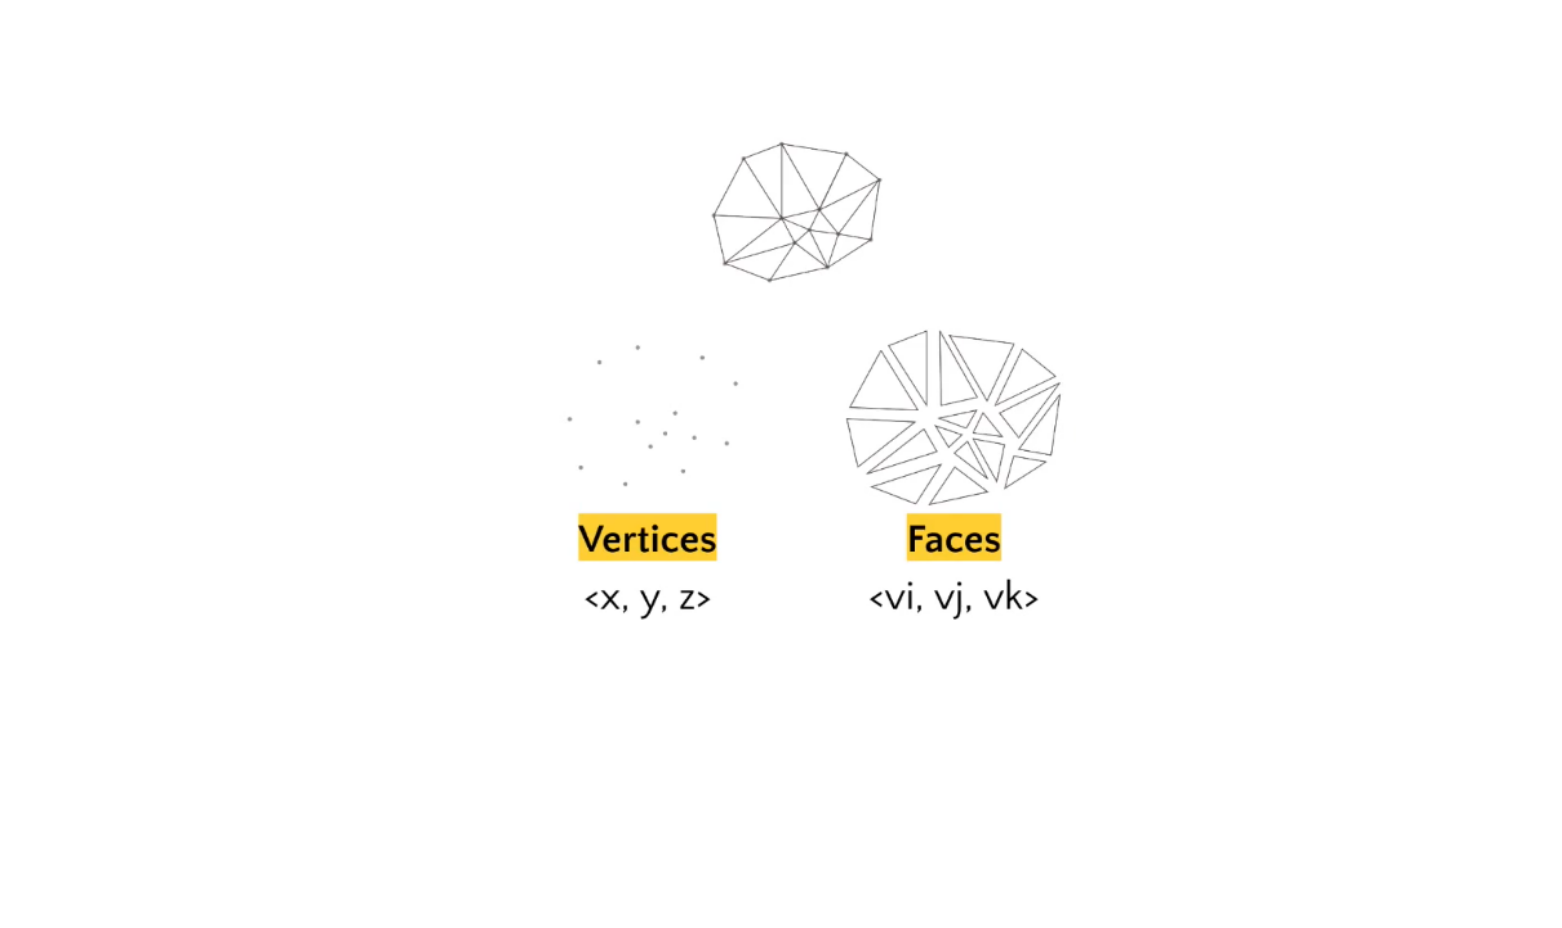

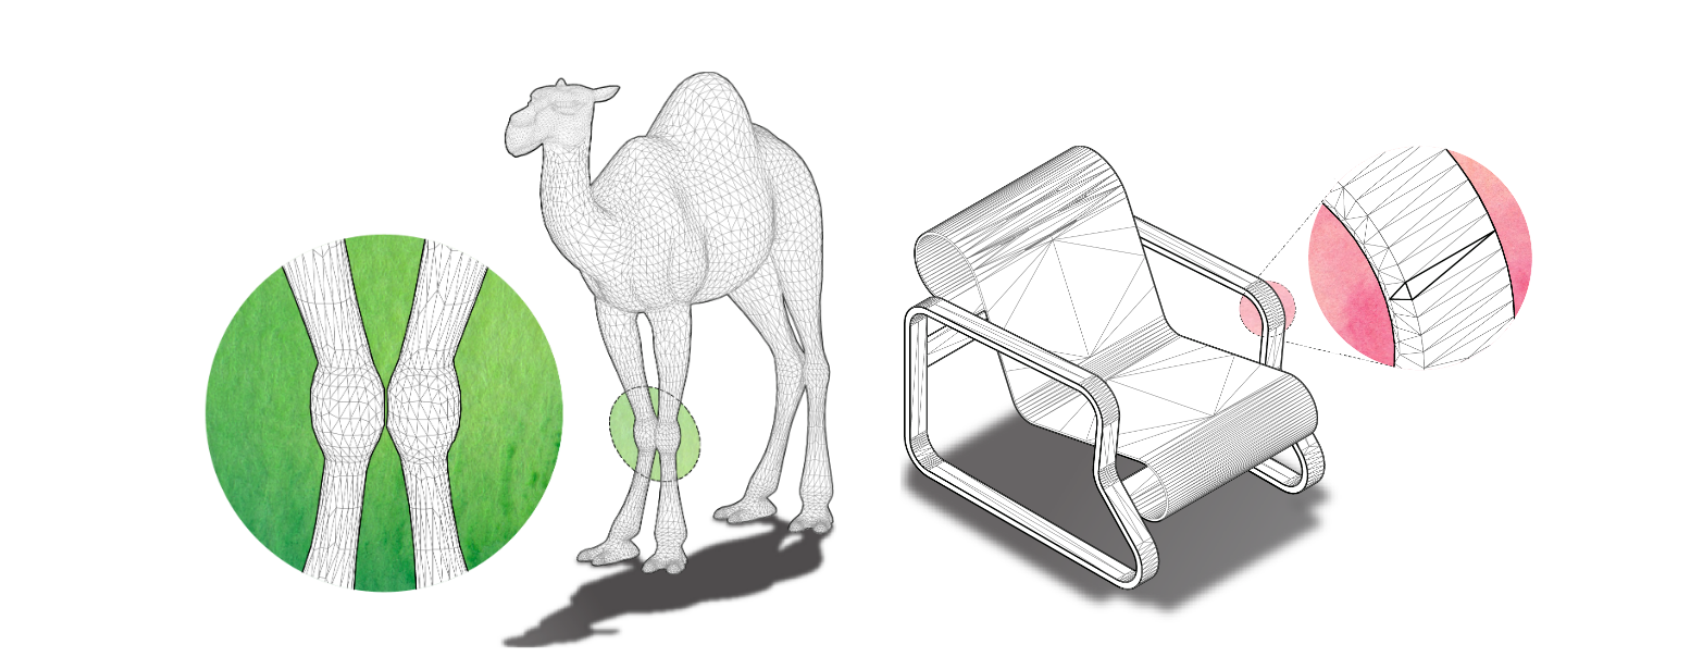

In [ ]:
mesh = trimesh.load("./shrec_16/alien/test/T547.obj")
mesh.show()

## Invariant Convolutions

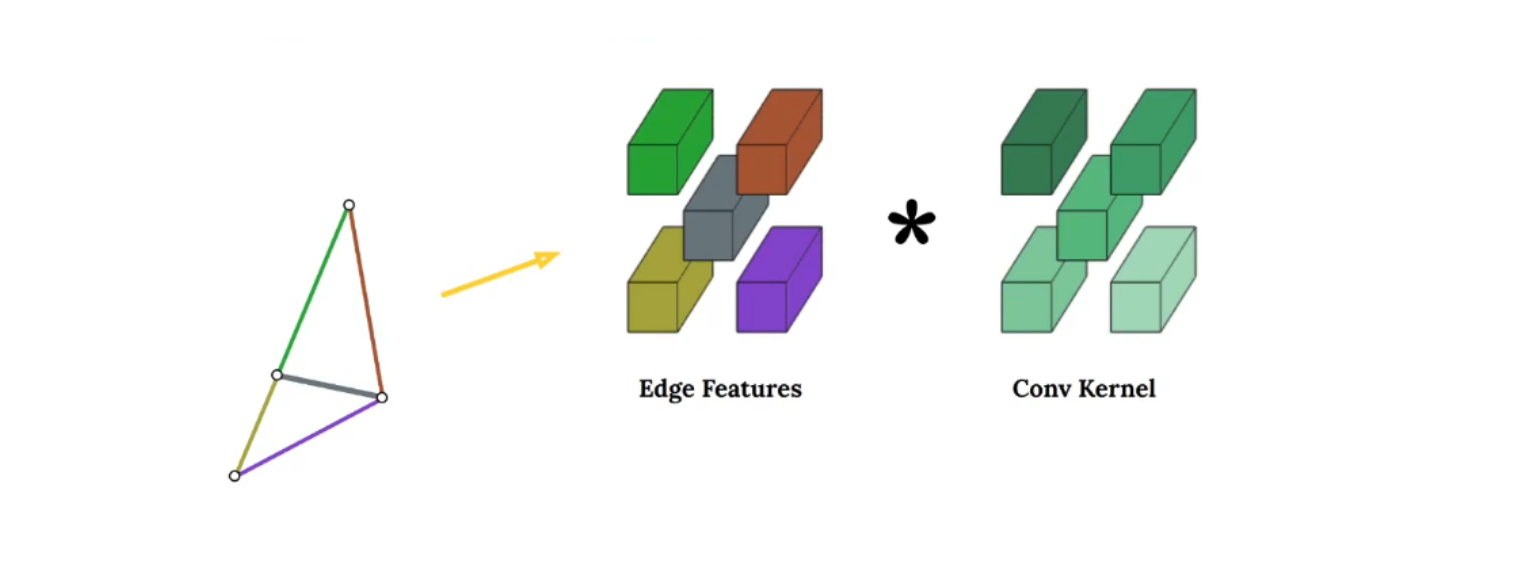

### **Problem:** ambiguity

Should be invariant to similarity transformations (rotation, translation, scale)

### input descriptor

5-dim feature vector

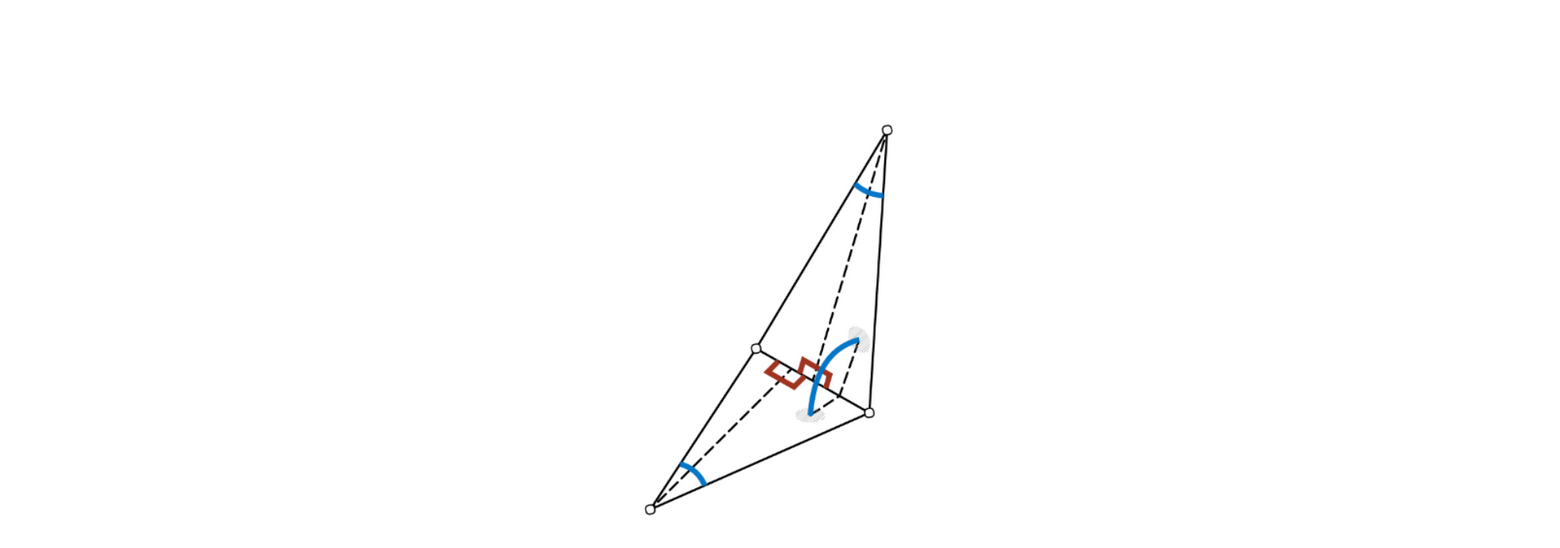


### apply the convolutional kernel on a simple symmetric feature

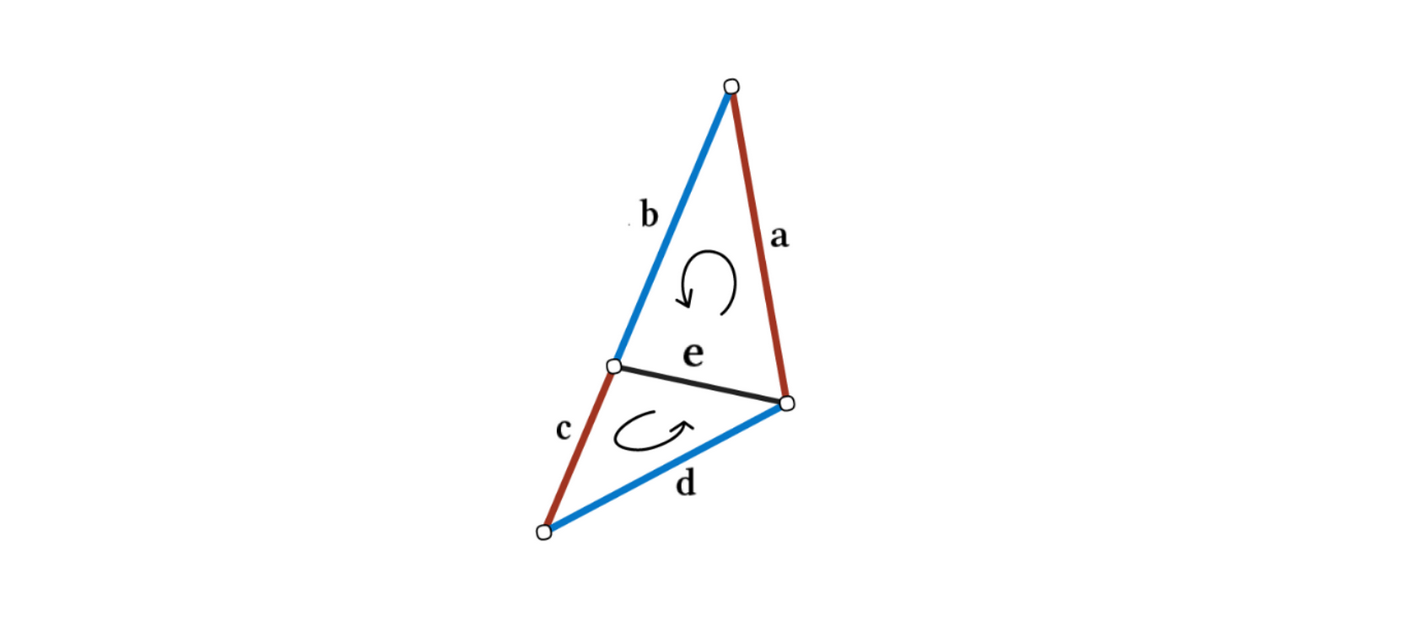

$$
e \rightarrow (a+c, |a - c|, b+d, |b - d|)
$$

In [ ]:
dataroot = 'shrec_16' # path to meshes (should have subfolders train, test)

export_folder = './collapses' # exports intermediate collapses to this folder
if not os.path.exists(export_folder):
    os.makedirs(export_folder)


batch_size = 16

test_dataset = DataLoader(dataroot,
                          export_folder,
                          device=device,
                          batch_size=batch_size,
                          phase='test',
                          num_aug=1)


train_dataset = DataLoader(dataroot,
                           export_folder,
                           device=device,
                           batch_size=batch_size,
                           phase='train',
                           num_aug=20)

print(len(test_dataset), len(train_dataset))

In [ ]:
test_dataset.dataset[0]['edge_features'].shape

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MeshConv(nn.Module):
    """ Computes convolution between edges and 4 incident (1-ring) edge neighbors
    in the forward pass takes:
    x: edge features (Batch x Features x Edges)
    mesh: list of mesh data-structure (len(mesh) == Batch)
    and applies convolution
    """
    def __init__(self, in_channels, out_channels, k=5, bias=True):
        super(MeshConv, self).__init__()
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=(1, k), bias=bias)
        self.k = k

    def __call__(self, edge_f, mesh):
        return self.forward(edge_f, mesh)

    def forward(self, x, mesh):
        x = x.squeeze(-1)
        G = torch.cat([self.pad_gemm(i, x.shape[2], x.device) for i in mesh], 0)
        # build 'neighborhood image' and apply convolution
        G = self.create_GeMM(x, G)
        x = self.conv(G)
        return x

    def flatten_gemm_inds(self, Gi):
        (b, ne, nn) = Gi.shape
        ne += 1
        batch_n = torch.floor(torch.arange(b * ne, device=Gi.device).float() / ne).view(b, ne)
        add_fac = batch_n * ne
        add_fac = add_fac.view(b, ne, 1)
        add_fac = add_fac.repeat(1, 1, nn)
        # flatten Gi
        Gi = Gi.float() + add_fac[:, 1:, :]
        return Gi

    def create_GeMM(self, x, Gi):
        """ gathers the edge features (x) with from the 1-ring indices (Gi)
        applys symmetric functions to handle order invariance
        returns a 'fake image' which can use 2d convolution on
        output dimensions: Batch x Channels x Edges x 5
        """
        Gishape = Gi.shape
        # pad the first row of  every sample in batch with zeros
        padding = torch.zeros((x.shape[0], x.shape[1], 1), requires_grad=True, device=x.device)
        # padding = padding.to(x.device)
        x = torch.cat((padding, x), dim=2)
        Gi = Gi + 1 #shift

        # first flatten indices
        Gi_flat = self.flatten_gemm_inds(Gi)
        Gi_flat = Gi_flat.view(-1).long()
        #
        odim = x.shape
        x = x.permute(0, 2, 1).contiguous()
        x = x.view(odim[0] * odim[2], odim[1])

        f = torch.index_select(x, dim=0, index=Gi_flat)
        f = f.view(Gishape[0], Gishape[1], Gishape[2], -1)
        f = f.permute(0, 3, 1, 2)

        
        # apply the symmetric functions for an equivariant conv
        ### Your code here ###
        <...>
        
        return f

    def pad_gemm(self, m, xsz, device):
        """ extracts one-ring neighbors (4x) -> m.gemm_edges
        which is of size #edges x 4
        add the edge_id itself to make #edges x 5
        then pad to desired size e.g., xsz x 5
        """
        padded_gemm = torch.tensor(m.gemm_edges, device=device).float()
        padded_gemm = padded_gemm.requires_grad_()
        padded_gemm = torch.cat((torch.arange(m.edges_count, device=device).float().unsqueeze(1), padded_gemm), dim=1)
        # pad using F
        padded_gemm = F.pad(padded_gemm, (0, 0, 0, xsz - m.edges_count), "constant", 0)
        padded_gemm = padded_gemm.unsqueeze(0)
        return padded_gemm


### Pooling

-> Mesh simplification

Criteria: minimal geometric distortion -> delete edges with minimal l2 norm

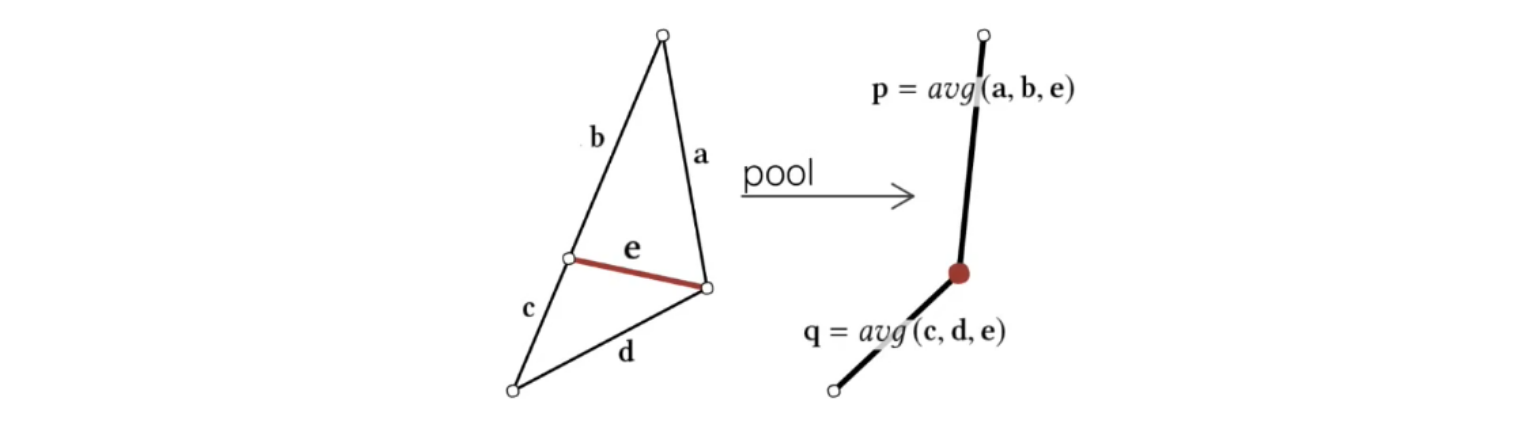

## Augmentation
### Remeshing

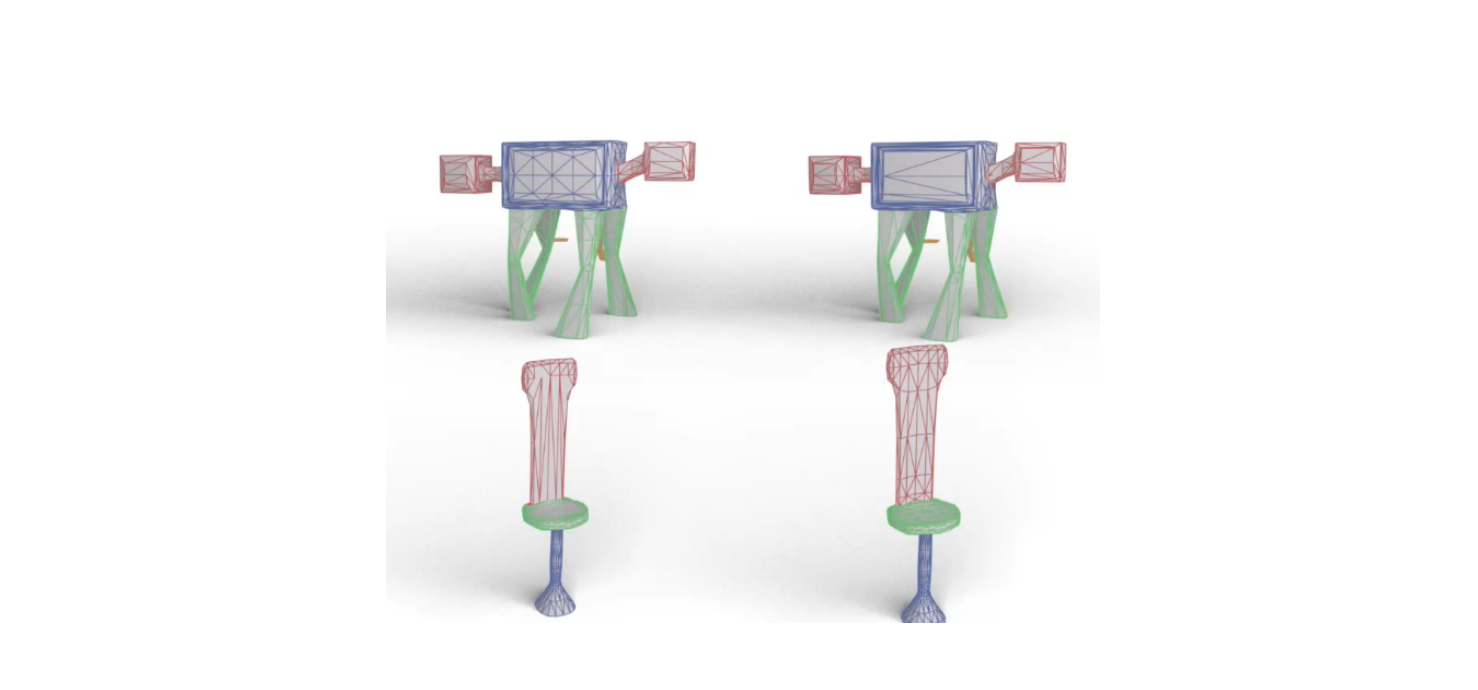

# MeshCNN architecture

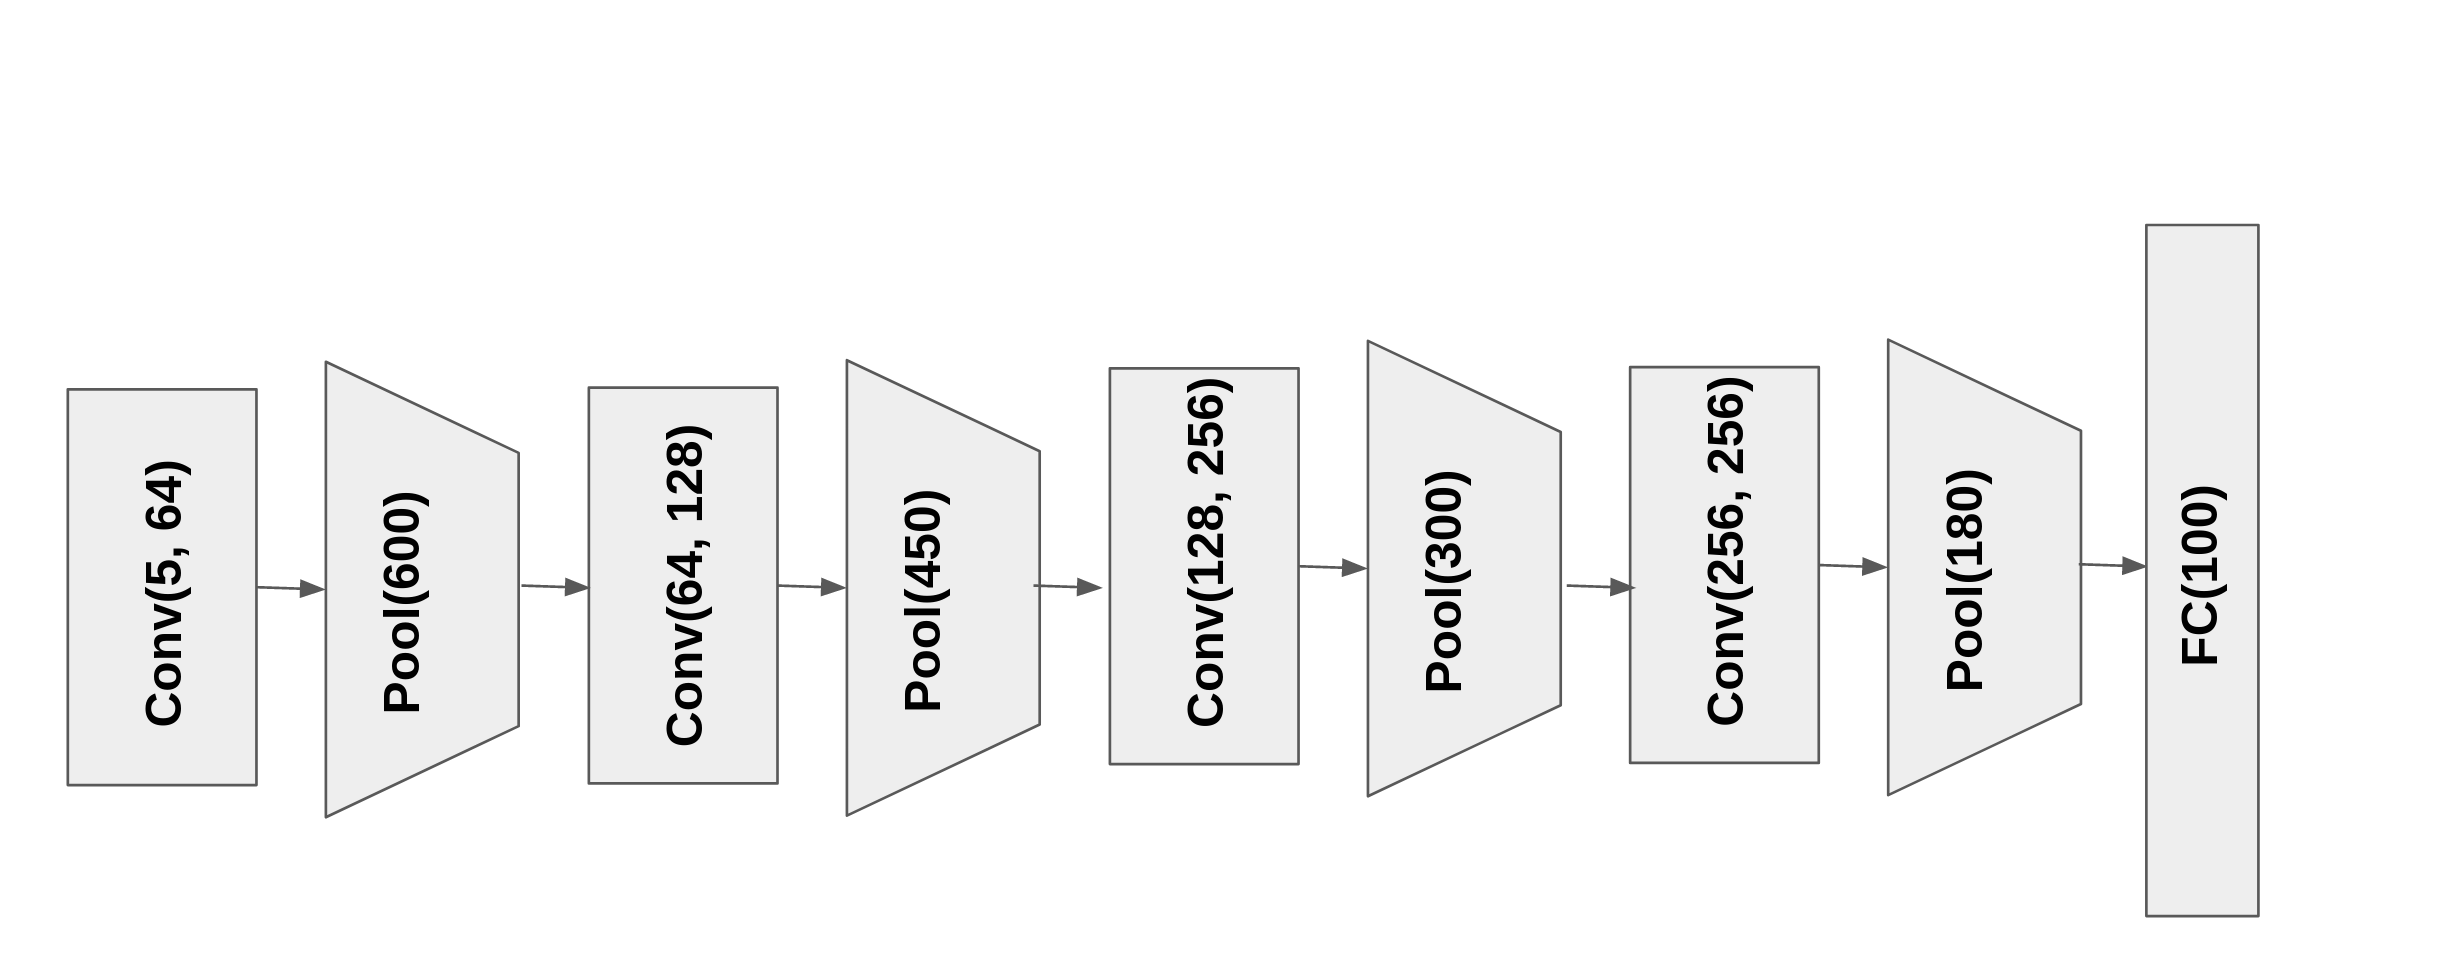

In [ ]:
from mesh_pooling import MeshPool

class MeshCNN(nn.Module):
    """Network for learning a global shape descriptor (classification)
    """
    def __init__(self, input_nc, nclasses,
                 num_groups=16):
        
        super(MeshCNN, self).__init__()

        ### Your code here ###
        
        # Use groupNorm with num_groups=16
        # Use AvgPool1d 

        
        <...>

        
        
    def forward(self, x, mesh):
        ### Your code here ###
        <...>
        
        return x


class MResConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(MResConv, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels

        ### Your code here ###
        <...>

    def forward(self, x, mesh):
        ### Your code here ###
        <...>
        
        return x


In [ ]:
input_nc = train_dataset.dataset.ninput_channels
nclasses = train_dataset.dataset.nclasses


net = MeshCNN(input_nc, nclasses)

if len(gpu_ids) > 0:
    assert(torch.cuda.is_available())
    net.cuda(gpu_ids[0])
    net = net.cuda()
    net = torch.nn.DataParallel(net, gpu_ids)

In [ ]:
from net_utils import init_weights, load_network

init_weights(net, init_type='normal', init_gain=0.02)

load_network(net, path="latest_net.pth", device=device)

In [ ]:
def test(net, dataset):
    net.eval()

    ncorrect, nexamples = 0, 0
    for i, data in enumerate(dataset):

        edge_features = torch.from_numpy(data['edge_features']).float().to(device).requires_grad_(False)
        labels = torch.from_numpy(data['label']).long().to(device)
        mesh = data['mesh']

        with torch.no_grad():
            out = net(edge_features, mesh)
            preds = out.data.max(1)[1] 

            ncorrect += preds.eq(labels).sum()
            nexamples += len(labels)
    acc = float(ncorrect) / nexamples
    return acc

In [ ]:
test(net, test_dataset)

## Visualize 

In [ ]:
import trimesh

mesh = trimesh.load("./shrec_16/alien/test/T547.obj")
mesh0 = trimesh.load("./collapses/T547_0.obj")
mesh1 = trimesh.load("./collapses/T547_1.obj")
mesh2 = trimesh.load("./collapses/T547_2.obj")
mesh3 = trimesh.load("./collapses/T547_3.obj")
mesh4 = trimesh.load("./collapses/T547_4.obj")

In [ ]:
mesh.show()

In [ ]:
mesh4.show()